# Needed libraries:

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
# data frame and visualization libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

warnings.filterwarnings("ignore")

#  scaling module
from sklearn.preprocessing import StandardScaler

# validation and split libraries
from sklearn.model_selection import train_test_split


# Statistical model libraries
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)

# hyper parameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

/Users/paulwilliams/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/paulwilliams/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### Functions we will use

In [3]:
# This function allows us to view the train and val Area under the curve scores
def scores(model, X_train, X_val, y_train, y_val):
    train_prob = model.predict_proba(X_train)[:, 1]
    val_prob = model.predict_proba(X_val)[:, 1]
    train = roc_auc_score(y_train, train_prob)
    val = roc_auc_score(y_val, val_prob)
    print("train:", round(train, 2), "test:", round(val, 2))

In [4]:
# This function annotates our graph with the appropriate axes names
def annot(fpr, tpr, thr):
    k = 0
    for i, j in zip(fpr, tpr):
        if k % 50 == 0:
            plt.annotate(round(thr[k], 2), xy=(i, j), textcoords="data")
        k += 1

In [5]:
# This function allows us to plot our roc curve based off our predicted probabilities from our Train and validation sets
def roc_plot(model, X_train, y_train, X_val, y_val):
    train_prob = model.predict_proba(X_train)[:, 1]
    val_prob = model.predict_proba(X_val)[:, 1]
    plt.figure(figsize=(7, 7))
    for data in [[y_train, train_prob], [y_val, val_prob]]:  # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.ylabel("TPR (power)")
    plt.xlabel("FPR (alpha)")
    plt.legend(["train", "test"])
    plt.show()

In [6]:
# This model visualizes our optimal model results using seaborn heat map allowing us to see what parameters to tweak
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [
        col
        for col in opt.columns
        if ("mean" in col or "std" in col) and "time" not in col
    ]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params, opt[cols]], axis=1, sort=False)

    plt.figure(figsize=[15, 4])
    plt.subplot(121)
    sns.heatmap(
        pd.pivot_table(
            opt,
            index="max_depth",
            columns="min_samples_leaf",
            values="mean_train_score",
        )
        * 100
    )
    plt.title("ROC_AUC - Training")
    plt.subplot(122)
    sns.heatmap(
        pd.pivot_table(
            opt, index="max_depth", columns="min_samples_leaf", values="mean_test_score"
        )
        * 100
    )
    plt.title("ROC_AUC - Validation")


#     return opt

## Load the Data:

In [7]:
# Loaded from a notebook that renamed our columns and applied onehot encoding
baseline_df = pd.read_csv("../data/telecom_cleaned.csv")

In [8]:
print("-----------------------------------------")
print("The Dataframe has:", baseline_df.shape[1], "columns")
print("The Dataframe has:", baseline_df.shape[0], "rows")
print("-----------------------------------------")

-----------------------------------------
The Dataframe has: 22 columns
The Dataframe has: 3333 rows
-----------------------------------------


In [9]:
list(baseline_df.columns)

['Unnamed: 0',
 'state',
 'account_length',
 'area_code',
 'phone_number',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'churn',
 'international_plan_yes',
 'voice_mail_plan_yes']

## Create Train/Test/Split and Validation sets

In [10]:
# feature selection: we decided to drop these columns as they do not transfer over to international telecom data as the company we are working for is Syriatel
X = baseline_df.drop(
    ["Unnamed: 0", "churn", "state", "phone_number", "area_code", "account_length"],
    axis=1,
)
y = baseline_df.loc[:, ["churn"]]

In [11]:
# rows and columns after the drops
print("-----------------------------------------")
print("X has:", X.shape[1], "columns")
print("X has:", X.shape[0], "rows")
print("-----------------------------------------")
print("Y has:", y.shape[1], "columns")
print("Y has:", y.shape[0], "rows")
print("-----------------------------------------")

-----------------------------------------
X has: 16 columns
X has: 3333 rows
-----------------------------------------
Y has: 1 columns
Y has: 3333 rows
-----------------------------------------


In [12]:
# Create our train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Create our validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1
)

In [13]:
# Rows and columns of the train, val, and test splits
print("------------------------------------------------")
print("The X and Y Train shape is:", X_train.shape, y_train.shape)
print("The X and Y Val shape is:", X_val.shape, y_val.shape)
print("The X and Y Test shape is:", X_test.shape, y_test.shape)
print("Totals :", X_train.shape[0] + X_val.shape[0] + X_test.shape[0], "Rows")
print("------------------------------------------------")

------------------------------------------------
The X and Y Train shape is: (2132, 16) (2132, 1)
The X and Y Val shape is: (534, 16) (534, 1)
The X and Y Test shape is: (667, 16) (667, 1)
Totals : 3333 Rows
------------------------------------------------


In [14]:
# Our positive and negative value counts for our categories
baseline_df["churn"].value_counts()

False    2850
True      483
Name: churn, dtype: int64

## Decision Tree

I added some manual tweaks to see if i can increase the performance before i do a grid search

In [20]:
# manual tweaks
tree_clf = DecisionTreeClassifier(
    min_samples_leaf=5, max_depth=4, class_weight="balanced", random_state=140
)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=140, splitter='best')

train: 0.9 test: 0.89


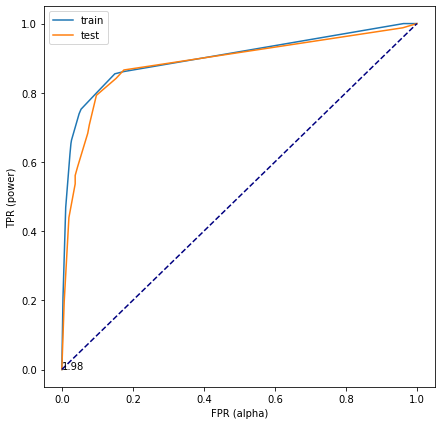

In [21]:
scores(tree_clf, X_train, X_val, y_train, y_val)
roc_plot(tree_clf, X_train, y_train, X_val, y_val)

In [22]:
dot_data = StringIO()

In [23]:
export_graphviz(
    tree_clf,
    out_file=dot_data,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

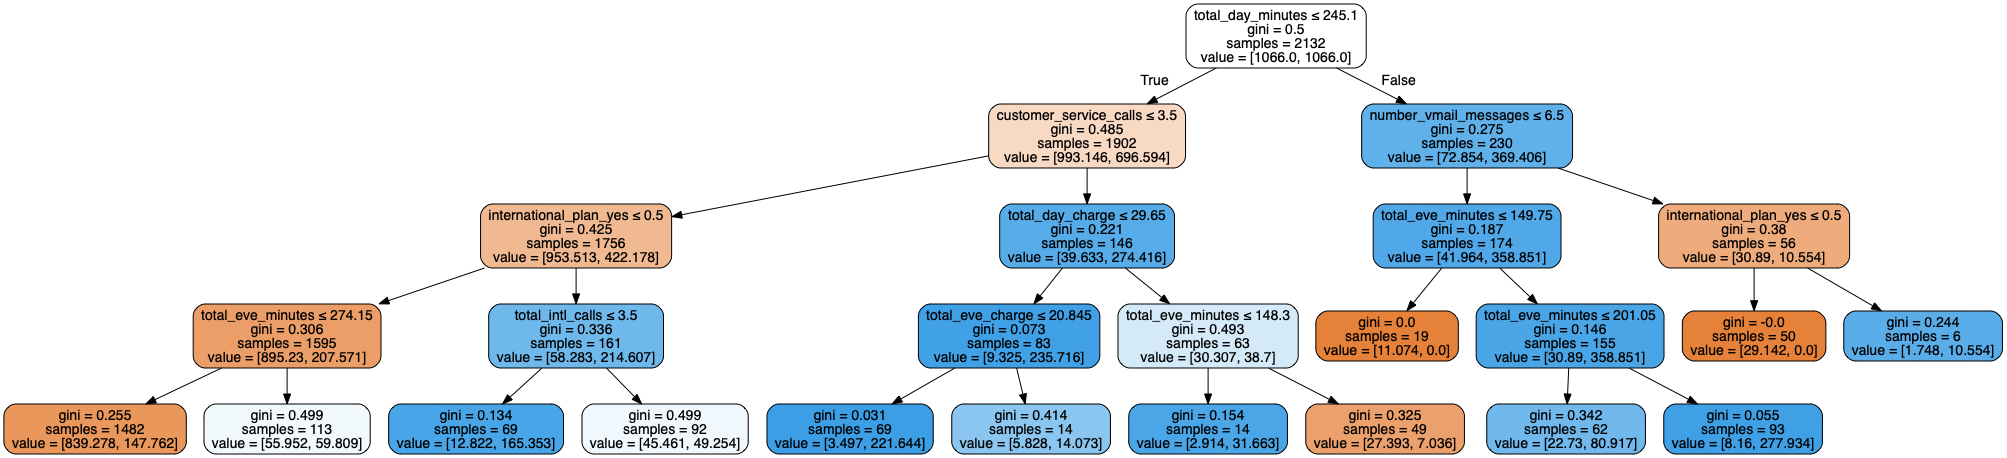

In [24]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# value= [notchurn, churn]

These optimizations aren't bad but i am sure we can do better with grid search.

## Grid search with the decision tree

We will use stratified kfold to validate and ensure randomness among each fold when we apply our grid search

In [25]:
skf = StratifiedKFold(n_splits=5, random_state=140)

train: 0.94 test: 0.9
{'max_depth': 11, 'min_samples_leaf': 47}
CPU times: user 1.04 s, sys: 22.5 ms, total: 1.06 s
Wall time: 1.24 s


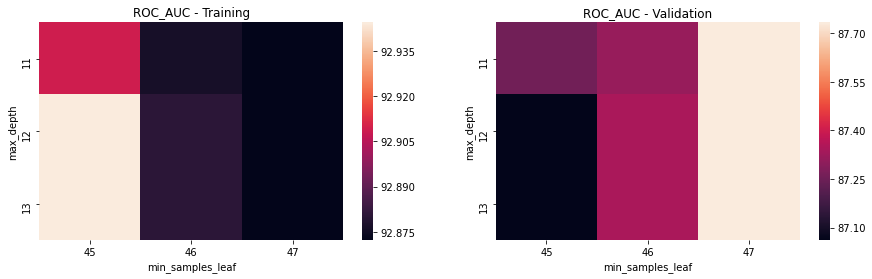

In [31]:
%%time
param_grid = {'max_depth':range(11,14), 'min_samples_leaf':range(45,48)}

opt_model = GridSearchCV(tree_clf, param_grid, cv=skf, scoring='roc_auc', return_train_score=True)
opt_model.fit(X_train,y_train)
d_tree_best_model = opt_model.best_estimator_

scores(d_tree_best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.94 test: 0.9


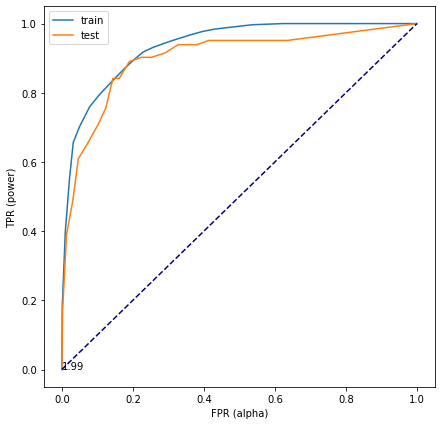

In [32]:
scores(d_tree_best_model, X_train, X_val, y_train, y_val)
roc_plot(d_tree_best_model, X_train, y_train, X_val, y_val)

we like this model best

# Chosen model (Decision Tree)

In [45]:
# positive probabilites of our val set
probs_val = d_tree_best_model.predict_proba(X_val)
probs_val[:, 1]

array([0.        , 0.        , 0.        , 0.24353384, 0.9939017 ,
       0.        , 0.10583266, 0.48987947, 0.        , 0.9939017 ,
       0.32564765, 0.96194394, 0.        , 0.25466444, 0.25466444,
       0.32564765, 0.        , 0.10583266, 0.10054423, 0.        ,
       0.96194394, 0.66800584, 0.27392542, 0.46303797, 0.27392542,
       0.03702429, 0.        , 0.48987947, 0.        , 0.        ,
       0.10054423, 0.        , 0.03702429, 0.71916866, 0.9280355 ,
       0.        , 0.2232666 , 0.24353384, 0.        , 0.25466444,
       0.24353384, 0.        , 0.52002437, 0.48987947, 0.9280355 ,
       0.        , 0.96194394, 0.24353384, 0.        , 0.        ,
       0.2232666 , 0.        , 0.27392542, 0.10583266, 0.        ,
       0.52002437, 0.16986301, 0.10583266, 0.2232666 , 0.25466444,
       0.96194394, 0.        , 0.10054423, 0.        , 0.24353384,
       0.        , 0.32564765, 0.52002437, 0.52002437, 0.03702429,
       0.24353384, 0.        , 0.71916866, 0.90782311, 0.25466

In [46]:
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, probs_val[:, 1])

In [47]:
# Train and test probabilities
probs_train = d_tree_best_model.predict_proba(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, probs_train[:, 1])

probs_test = d_tree_best_model.predict_proba(X_test)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probs_test[:, 1])

## The validation Test:

train: 0.94 test: 0.9


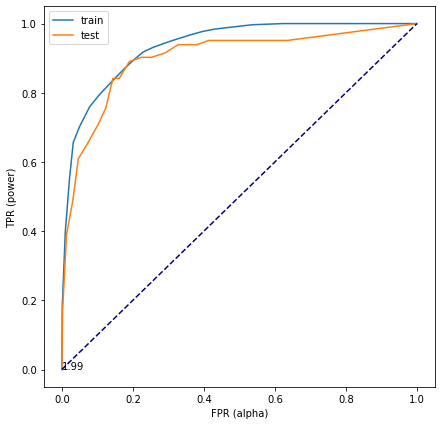

In [48]:
# Roc curve for train and validation sets
scores(d_tree_best_model, X_train, X_val, y_train, y_val)
roc_plot(d_tree_best_model, X_train, y_train, X_val, y_val)

### Feature interpretation

In [50]:
# Feature importances:

for name, score in zip(X_train.columns, d_tree_best_model.feature_importances_):

    print(name, score)

number_vmail_messages 0.0
total_day_minutes 0.24451096045748533
total_day_calls 0.01645518252909701
total_day_charge 0.03546667237956186
total_eve_minutes 0.06277907845544838
total_eve_calls 0.008130032559375135
total_eve_charge 0.0
total_night_minutes 0.018746697788802513
total_night_calls 0.014826926229536531
total_night_charge 0.008745648655658318
total_intl_minutes 0.0011174518254158541
total_intl_calls 0.034611177685335184
total_intl_charge 0.0
customer_service_calls 0.2591366209076788
international_plan_yes 0.24686039599906248
voice_mail_plan_yes 0.048613154527542515


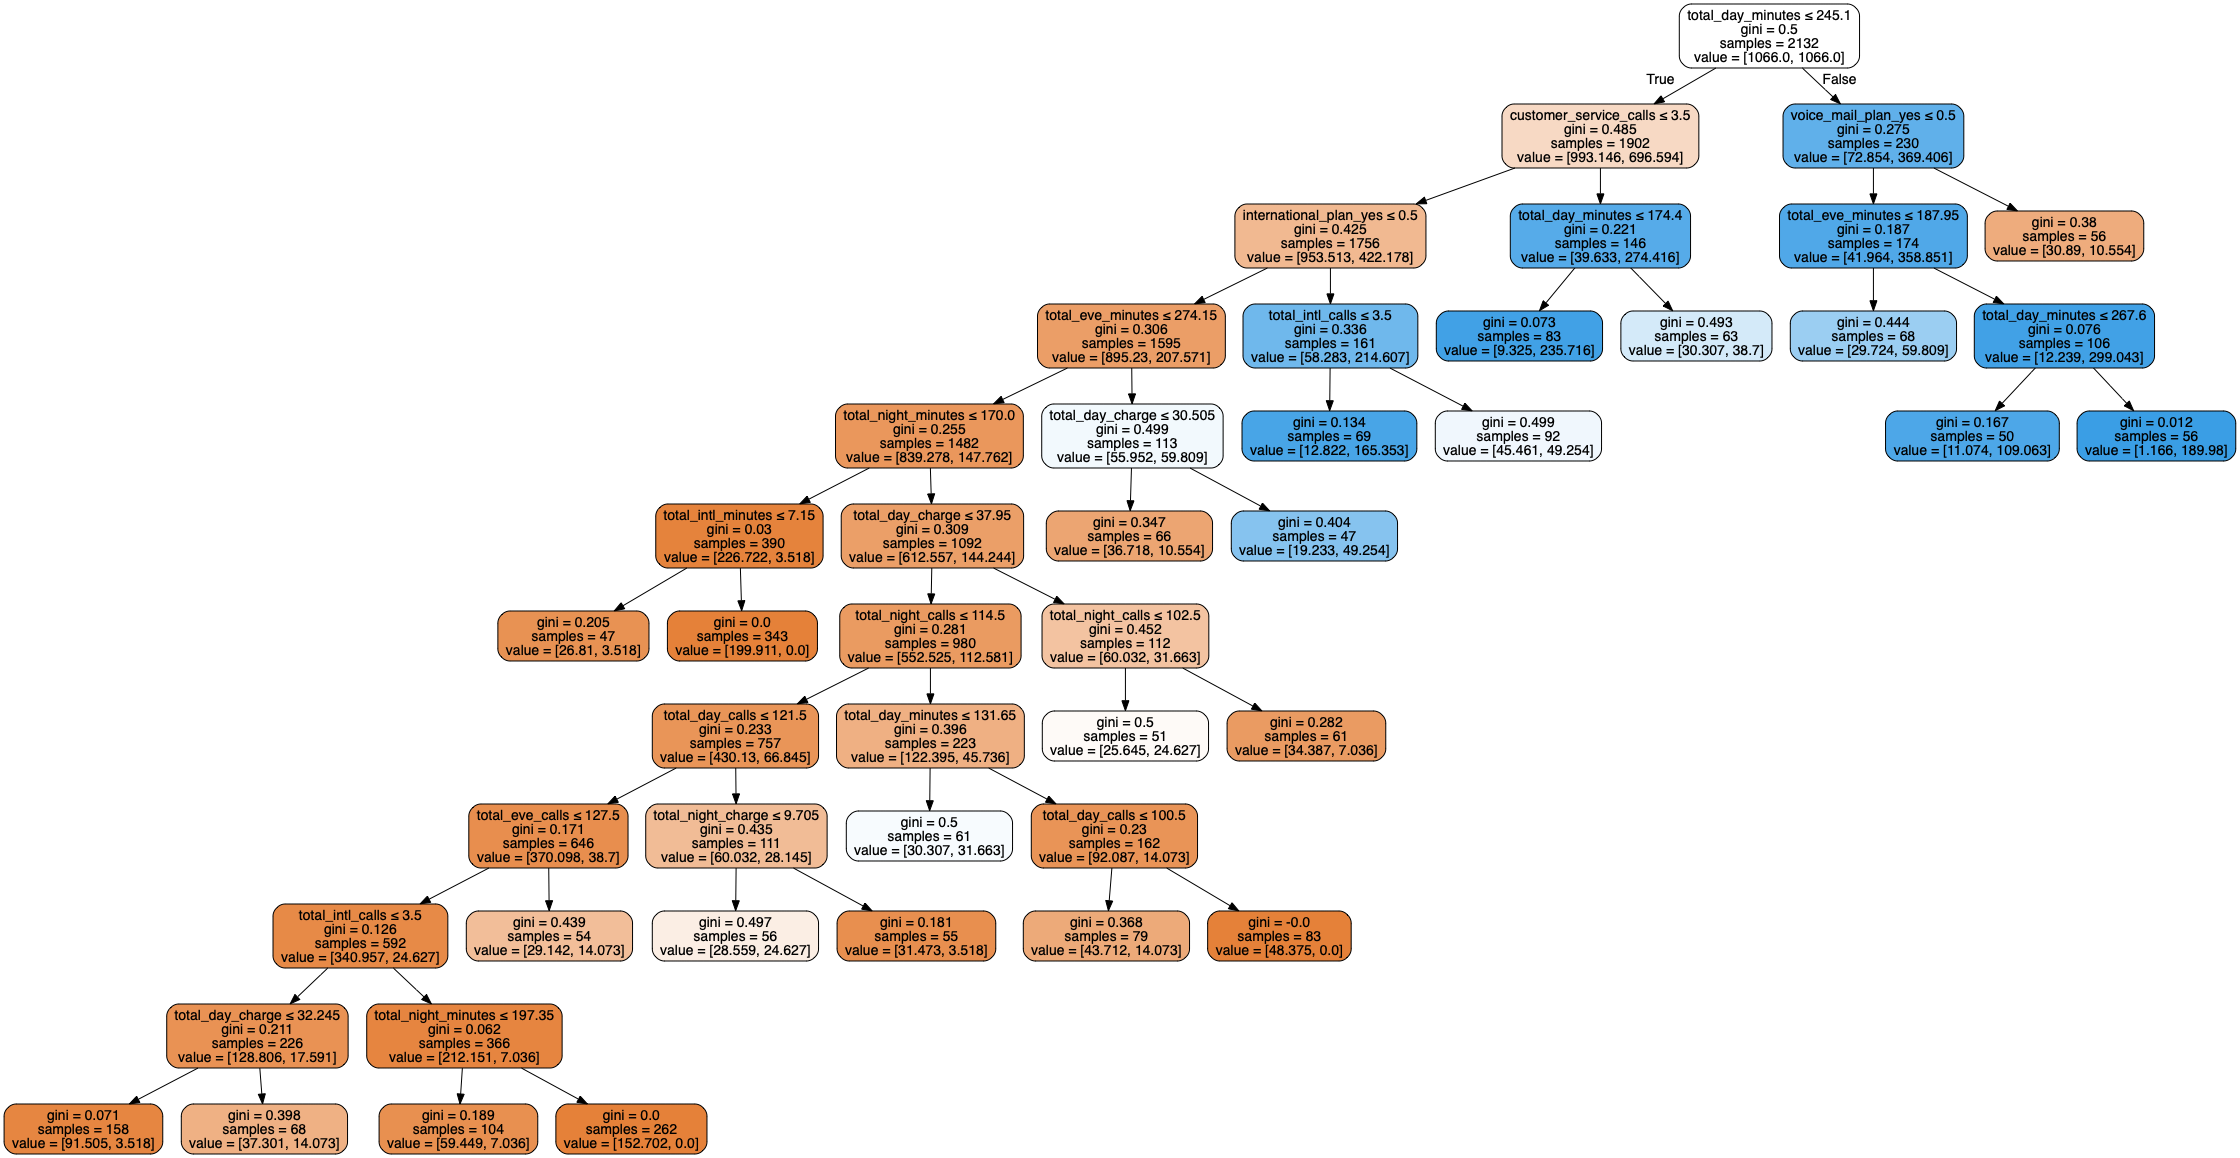

In [51]:
dot_data = StringIO()

export_graphviz(
    d_tree_best_model,
    out_file=dot_data,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True,
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# value= [notchurn, churn]

We decided to choose the decision tree as it was our highest performer on our validation set. Although random forrest performed higher it was quite overfit.

## Threshold Selection

### Prevalance


According to our research, it can cost 50 times less to keep an existing customer than to aquire a new one.

The industry average for churn rate is around 1.9-2.1 percent per month (10-67% per year) we will go with the prevalence of our dataset

In [52]:
# select prevalence based on research:
prevalence = y["churn"].value_counts()[1] / y["churn"].value_counts()[0]
prevalence

0.1694736842105263

### cost of FP, TN, FN, and TP

In [53]:
# According to our source, it costs 50 times less to keep an existing customer than it does to acquire a new one
# A false positive would indicate that we wrongfully predicted that a customer would churn when they actually wouldn't have
# According to candian telecom data that retention cost can be  C$11.74
FPc = 11.74
# The cost of a True negative or predicting that there truly would not be a customer churn when there really wasn't would not cost us anything.
TNc = 0
# The cost of a False negative or a falsely saying that a customer wouldn't churn when they actually would is quite high.
# This cost is 50 times higher than our False positive according to our source
FNc = 11.74 * 50
# The cost of our True positive, or correctly predicting a churn when our customer actually would have churned would be the same price as our false positive
TPc = 11.74

# References:
# http://www.dbmarketing.com/telecom/churnreduction.html
# https://telecoms.com/opinion/churn-is-breaking-the-telecoms-market-heres-how-to-fix-it/
# https://www.commsmea.com/11306-customer-acquisition

### Metz parameter:

In [54]:
m = (1 - prevalence) / prevalence * (FPc - TNc) / (FNc - TPc)
m

0.10001267587780455

### Calculate FM

In [61]:
# FM is used to see how much threshold should be applied to our model
fm_list = tpr_test - (m * fpr_test)
list(zip(fm_list.tolist(), thresholds_test.tolist()))

[(0.0, 1.9939017026929116),
 (0.1834977001858609, 0.9939017026929116),
 (0.3859974100218742, 0.9619439363848309),
 (0.4447611309912737, 0.9280354964427986),
 (0.5149593180065857, 0.9078231074676572),
 (0.5636947265452262, 0.7191686560876281),
 (0.6426908415780376, 0.6680058436815194),
 (0.6900200965015245, 0.5608083623693381),
 (0.7575817454884234, 0.5200243704305447),
 (0.7551209766619045, 0.5109414284384021),
 (0.7837997603390274, 0.48987947197245074),
 (0.781866299118191, 0.4630379746835443),
 (0.775890146253788, 0.27392541560581113),
 (0.8035143147195457, 0.2546644388749652),
 (0.8186494019280255, 0.24353383708931156),
 (0.8146067102844586, 0.22326660156250014),
 (0.8325541047232459, 0.1698630136986302),
 (0.8397701099236974, 0.11600177586097546),
 (0.8454041923071011, 0.10583265825714643),
 (0.840306885452169, 0.10054422516629102),
 (0.851223511815188, 0.037024291497975856),
 (0.8999873241221954, 0.0)]

highest fm score is 0.8999873241221954 and it corresponds to a threshold of 0

## The big test:

train: 0.94 test: 0.84


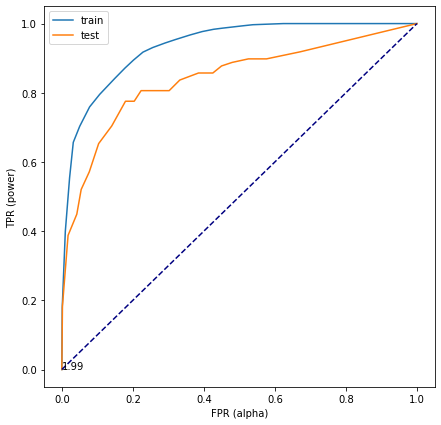

In [49]:
# Roc curve for train and test sets
scores(d_tree_best_model, X_train, X_test, y_train, y_test)
roc_plot(d_tree_best_model, X_train, y_train, X_test, y_test)

### Confusion matrix:

In [62]:
probs_list = probs_test[:, 1].tolist()

my_results = []
for x in probs_list:
    if x > 0: # our FM suggest 0 threshold
        my_results.append(1)
    else:
        my_results.append(0)
my_results

confusion = []
for i, real in enumerate(y_test["churn"].tolist()):
    if my_results[i] == real:
        if my_results[i] == 0:
            confusion.append("TN")
        else:
            confusion.append("TP")
    else:
        if my_results[i] == 0:
            confusion.append("FN")
        else:
            confusion.append("FP")

pd.Series(confusion).value_counts()

FP    382
TN    187
TP     90
FN      8
dtype: int64

### Our models monetary costs:
Explaining our TPc, FPc, FNc, TNc costs and the logic behind them in a more understandable way

In [86]:
print(
    "The cost of our model thinking there is a possible churn when there actually isn't:",
    383 * FPc,
)
print(
    "The amount the company spends when our model makes an accurate prediction of a churned customer:",
    90 * TPc,
    "saving :",
    (90 * FNc) - (90 * TPc),
)


print("The cost of our models mistake of not detecting a churned customer:", FNc * 6)

The cost of our model thinking there is a possible churn when there actually isn't: 4496.42
The amount the company spends when our model makes an accurate prediction of a churned customer: 1056.6 saving : 51773.4
The cost of our models mistake of not detecting a churned customer: 3522.0


### Cost of implementation:
Based on our 667 customer test we ran we have found that these numbers align accurately with the costs to adopt our model.

In [74]:
print(
    "The cost to implement our model is:",
    (90 * TPc) + (383 * FPc) + (TNc * 0) + (FNc * 6),
)
print("The cost of not implementing our model is:", (90 * FNc))

The cost to implement our model is: 9075.02
The cost of not implementing our model is: 52830.0


We are happy with these costs because our model is prone to making type 1 errors. Based on our research the type 1 error only costs us 11 USD per customer whereas a type 2 error would cost us 521 USD per customer.

### Calculate alpha/power/precision/accuracy

In [65]:
y_predic = d_tree_best_model.predict(X_test)

In [82]:
# Model Evaluation metrics
alpha = 443 / (126 + 443)
print("Alpha : " + str(round(alpha, 2)))
power = 92 / (6 + 92)
print("Power : " + str(round(power, 2)))
print("Accuracy Score : " + str(round(accuracy_score(y_test, y_predic), 2)))
print("Precision Score : " + str(round(precision_score(y_test, y_predic), 2)))
print("Recall Score : " + str(round(recall_score(y_test, y_predic), 2)))

Alpha : 0.78
Power : 0.94
Accuracy Score : 0.79
Precision Score : 0.4
Recall Score : 0.78


### Stakeholder interpretation

* Alpha - There is a 27% chance that our model will say that a customer will churn when they actually wont.
* Power - There is a 7% chance that our model will say that a customer will not churn when they actually will.
* Precision - Of the recalled churners,  our model will get 39% of them right
* Accuracy - Of the 76% recalled it will accurately state there is a potential churn 85% of the time.
* Recall Score - The model will recall 76% of potential churners 

## Actionable plan for stakeholders:

Focus on customer service this is a big driving decision for consumer churn rates. The happier our costumers feel during this time the more likely they are to stay loyal. Maybe we can implement customer surveys at the end of some customer service calls to grade our employee's customer satisfaction. 